# The relationship between pupil size and activity in visual cortex

## Imports and constants

In [1]:
from datamatrix import io, plot
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datamatrix import operations as ops, DataMatrix, FloatColumn

In [2]:
MAX_ERR = np.inf
MIN_X = 2
MAX_X = 158
MIN_Y = 2
MAX_Y = 126
MIN_SD = 1
MAX_SD = 62
XC = 80
YC = 64
OUTLIERS = {5}
SRC_NIFTI = '../outputs/correlation-matrix.pkl'
SRC_LONGISH = '../outputs/longish-correlation-matrix.csv'
COLORS = {
    'V1': '#4DB6AC',
    'V2': '#009688',
    'V3': '#00796B',
    'V4': '#004D40'
}

## Read data

The data is read in two formats:

- A DataMatrix `dm` with one row for each roi/ subject, and the imaging data as NiftiColumns
- A "longish" DataMatrix `ldm` with one row for each voxel

The data is filtered based on the PRF properties to avoid poorly fitted PRFs from being included in the analysis.

In [3]:
def mask(nft, mask):
    
    """Set voxels that match the mask to nan"""
    
    nft.get_data()[mask] = np.nan


dm = io.readpickle(SRC_NIFTI)
dm = dm.sub != OUTLIERS
for row in dm:
    a = row.prf_err.get_data()
    x = row.prf_x.get_data()
    y = row.prf_y.get_data()
    sd = row.prf_sd.get_data()
    err = np.where(
        (a > MAX_ERR) |
        (x < MIN_X) | (x >= MAX_X) |
        (y < MIN_Y) | (y >= MAX_Y) |
        (sd < MIN_SD) | (sd >= MAX_SD)
    )
    n_poor = len(err[0])
    n_total = np.sum(~np.isnan(a))
    mask(row.prf_x, err)
    mask(row.prf_y, err)
    mask(row.prf_sd, err)
    mask(row.prf_err, err)
    mask(row.r_vc_pupil, err)
    mask(row.r_vc_lum, err)
dm.r_pupil = [np.nanmedian(row.r_vc_pupil.get_data()) for row in dm]
dm.r_lum = [np.nanmedian(row.r_vc_lum.get_data()) for row in dm]
dm.m_prf_err = [np.nanmedian(row.prf_err.get_data()) for row in dm]
dm.m_prf_sd = [np.nanmedian(row.prf_sd.get_data()) for row in dm]
dm.m_prf_absx = [np.nanmedian(np.abs(row.prf_x.get_data() - XC)) for row in dm]
dm.m_prf_absy = [np.nanmedian(np.abs(row.prf_y.get_data() - YC)) for row in dm]
dm.m_prf_ecc = [
    np.nanmedian(
        (
            (row.prf_y.get_data() - XC) ** 2 +
            (row.prf_y.get_data() - YC) ** 2
        ) ** .5
    )
    for row in dm
]
# And now the longish matrix
ldm = io.readtxt(SRC_LONGISH)
print('Total number of voxels: {}'.format(len(ldm)))
ldm = ldm.prf_err <= MAX_ERR
ldm = ldm.prf_x > MIN_X
ldm = ldm.prf_x <= MAX_X
ldm = ldm.prf_y > MIN_Y
ldm = ldm.prf_y <= MAX_Y
ldm = ldm.prf_sd > MIN_SD
ldm = ldm.prf_sd <= MAX_SD
ldm = ldm.sub != OUTLIERS
print('Number of voxels included in analysis: {}'.format(len(ldm)))

/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/sebastiaan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/home/sebastiaan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less
/home/sebastiaan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater_equal


Total number of voxels: 54720
Number of voxels included in analysis: 28079


# Plot: Correlations between pupil size, luminance, and visual-cortex activity

In [4]:
def roi_hist(ldm, col):
    
    plt.xlim(-.25, .25)
    plt.axvline(0, color='black', linestyle='-')
    for roi, rdm in ops.split(ldm.roi):
        sns.distplot(
            rdm[col],
            label=roi,
            hist=True,
            kde=False,
            bins=20,
            hist_kws={
                "alpha": .8,
                "color": COLORS[roi]
            }
        )
        plt.axvline(rdm[col].mean, color=COLORS[roi], linestyle=':')
    plt.ylabel('Voxel count')
    plt.xlabel('Correlation (r)')
    plt.legend()    

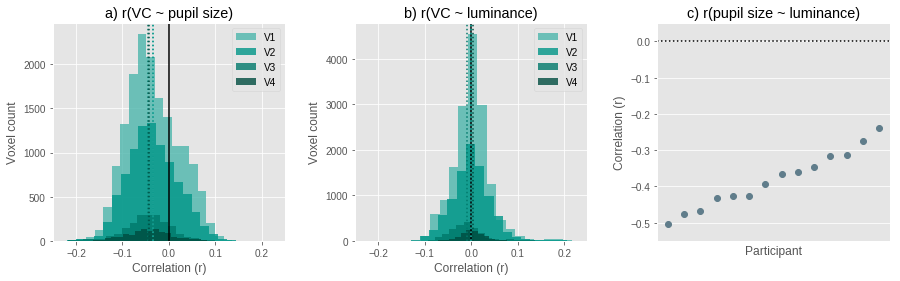

In [5]:
plt.figure(figsize=(15, 4))
plt.subplots_adjust(wspace=.3)
# Correlated pupil size and visual cortex
plt.subplot(1,3,1)
plt.title('a) r(VC ~ pupil size)')
roi_hist(ldm, 'r_vc_pupil')
# Correlated luminance and visual cortex
plt.subplot(1,3,2)
plt.title('b) r(VC ~ luminance)')
roi_hist(ldm, 'r_vc_lum')
plt.subplot(1,3,3)
# Correlated pupil size and luminance
plt.ylabel('Correlation (r)')
plt.title('c) r(pupil size ~ luminance)')
plt.axhline(0, color='black', linestyle=':')
r = sorted([sdm.r_lum_pupil.mean for sub, sdm in ops.split(dm.sub)])
plt.plot(r ,'o', color='#607D8B')
plt.xlabel('Participant')
plt.xticks([])
plt.ylim(-.55, .05)
plot.save('correlation-plot-dist', show=True)

# Plot: PRF properties

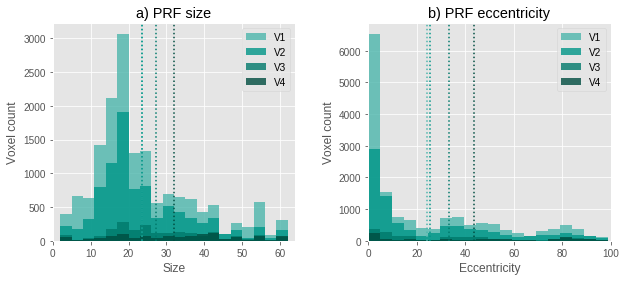

In [6]:
plt.figure(figsize=(10, 4))
plt.subplots_adjust(wspace=.3)
plt.subplot(1, 2, 1)
plt.title('a) PRF size')
roi_hist(ldm, 'prf_sd')
plt.xlabel('Size')
plt.xlim(0, 64)
plt.subplot(1, 2, 2)
plt.title('b) PRF eccentricity')
roi_hist(ldm, 'ecc')
plt.xlabel('Eccentricity')
plt.xlim(0, 100)
plot.save('prf-properties', show=True)

# Heatmaps

Various heatmaps to inspect how properties are distributed across the visual field, across all ROIs and for each ROI separately.

First some helper functions.

In [7]:
def density_map(ldm, downsample=8):

    a = np.zeros((2 * YC // downsample, 2 * XC // downsample))
    for i, row in enumerate(ldm):
        x = row.prf_x // downsample
        y = row.prf_y // downsample
        r = row.r_vc_pupil
        a[y, x] += 1
    plt.axis('off')
    sns.heatmap(a, cbar=False)
    
    
def size_map(ldm, downsample=16):

    a = np.empty((len(ldm), 2 * YC // downsample, 2 * XC // downsample))
    a[:] = np.nan
    for i, row in enumerate(ldm):
        x = row.prf_x // downsample
        y = row.prf_y // downsample
        r = row.prf_sd
        a[i, y, x] = r
    heatmap = np.nanmean(a, axis=0)
    plt.axis('off')
    sns.heatmap(heatmap, cbar=False)
        
    
def correlation_map(ldm, downsample=16):

    a = np.empty((len(ldm), 2 * YC // downsample, 2 * XC // downsample))
    a[:] = np.nan
    for i, row in enumerate(ldm):
        x = row.prf_x // downsample
        y = row.prf_y // downsample
        r = row.r_vc_pupil
        a[i, y, x] = r
    heatmap = np.nanmean(a, axis=0)
    plt.axis('off')
    sns.heatmap(heatmap, cbar=False, center=0)
    
    
def roi_plot(ldm, fnc):
        
    plt.figure(figsize=(15, 3))
    plt.subplots_adjust(wspace=.1, hspace=.1)
    plt.subplot(1, 5, 1)
    plt.title('All (V1 - V4)')
    fnc(ldm)
    plt.subplot(1, 5, 2)
    plt.title('V1')
    fnc(ldm.roi == 'V1')
    plt.subplot(1, 5, 3)    
    plt.title('V2')
    fnc(ldm.roi == 'V2')
    plt.subplot(1, 5, 4)    
    plt.title('V3')
    fnc(ldm.roi == 'V3')
    plt.subplot(1, 5, 5)
    plt.title('V4')
    fnc(ldm.roi == 'V4')


The density of PRFs.

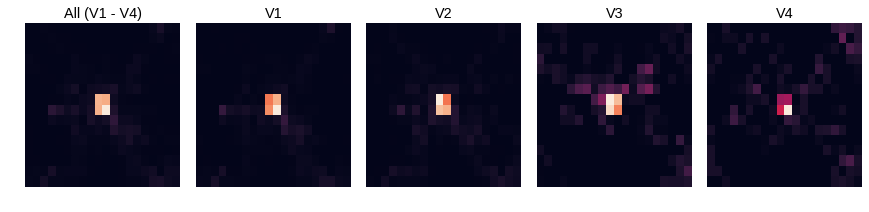

In [8]:
roi_plot(ldm, density_map)
plot.save('map-density', show=True)

/home/sebastiaan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice


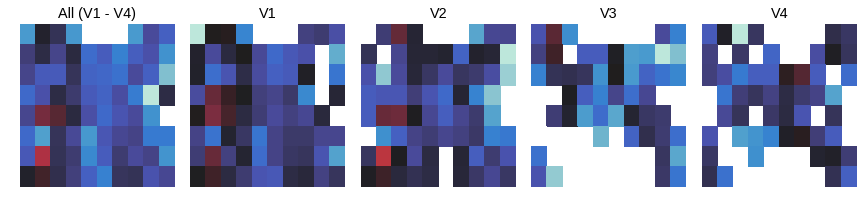

In [9]:
roi_plot(ldm, correlation_map)
plot.save('map-correlation', show=True)

/home/sebastiaan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


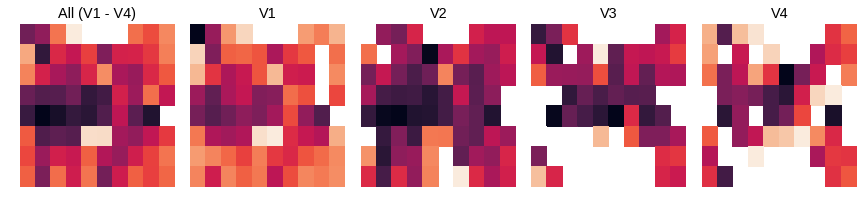

In [10]:
roi_plot(ldm, size_map)
plot.save('map-prf-size', show=True)

# Statistics

In [11]:
from datamatrix.rbridge import lme4
lme4.verbose = True

## Relationship between PRF properties and the VC-pupil correlation.

In [12]:
lme4.lmer(ldm, 'r_vc_pupil ~ (1|sub)')

df,effect,est,p,se,t
13.0009760433171,(Intercept),-0.0354230713708361,0.0021937950367967,0.00931408453315636,-3.80317263008906


In [13]:
lme4.lmer(ldm, 'r_vc_pupil ~ r_vc_lum + (1+r_vc_lum|sub)')

df,effect,est,p,se,t
13.0018200419373,(Intercept),-0.035738816264257,0.000720231524587362,0.00812636954007113,-4.39788223856039
12.9539534785499,r_vc_lum,-0.383269816308109,0.00280410071962346,0.104228036959357,-3.6772237824796


In [14]:
ldm.c_roi = ldm.roi @ (lambda roi: 0 if roi == 'V1' else 1 if roi == 'V2' else 2 if roi == 'V3' else 3)
lme4.lmer(ldm, 'r_vc_pupil ~ c_roi + (1+c_roi|sub)')

df,effect,est,p,se,t
13.0020930809907,(Intercept),-0.0339951036465369,0.00597266098620412,0.0103645228336611,-3.27994874362478
13.0454042682187,c_roi,-0.00222282621771775,0.412237436183787,0.00262419591629906,-0.847050406530861


In [15]:
lme4.lmer(ldm, 'r_vc_pupil ~ prf_y + (1+prf_y|sub)')

df,effect,est,p,se,t
12.9986599512063,(Intercept),-0.04731729020651,0.00128812671040944,0.0115819939169052,-4.08541832658411
13.0605936254542,prf_y,0.000174693287244108,0.0130617847868729,6.08439376553334e-05,2.87116997972262


In [16]:
lme4.lmer(ldm, 'r_vc_pupil ~ prf_x + (1+prf_x|sub)')

df,effect,est,p,se,t
13.02418608784,(Intercept),-0.0290035540341965,0.0253181398979004,0.0114849892741578,-2.52534445978605
13.1537929144295,prf_x,-8.82267281505176e-05,0.0648282917768699,4.378756794295e-05,-2.01488075943077


In [17]:
lme4.lmer(ldm, 'r_vc_pupil ~ ecc + (1+ecc|sub)')

df,effect,est,p,se,t
13.0027519749738,(Intercept),-0.0358380402216635,0.00329500981061874,0.00998352006299242,-3.58971985787963
12.9721704728422,ecc,3.506837546604e-05,0.623075574219154,6.96535926571851e-05,0.503468293999369


In [18]:
lme4.lmer(ldm, 'r_vc_pupil ~ prf_sd + (1+prf_sd|sub)')

df,effect,est,p,se,t
13.0060068037898,(Intercept),-0.0331873640781297,0.0169220464241994,0.0121219317909638,-2.7377949860161
13.0211264922096,prf_sd,-0.000117756795203715,0.552866539786059,0.000193294137497414,-0.609210381278586


## Basic PRF properties as a function of ROI

In [19]:
lme4.lmer(ldm, 'ecc ~ c_roi + (1+c_roi|sub)')

df,effect,est,p,se,t
13.024814501942,(Intercept),23.4166715988395,3.04009490880397e-07,2.45386905450817,9.54275516691452
12.9731517311834,c_roi,4.92952408836935,0.00274421335804041,1.33687912081582,3.68733718076258


In [20]:
lme4.lmer(ldm, 'prf_sd ~ c_roi + (1+c_roi|sub)')

df,effect,est,p,se,t
13.0037558125591,(Intercept),23.0998959422547,2.16098035657093e-08,1.93087321316844,11.9634452354069
13.0115103282085,c_roi,2.29181137939934,0.000568523910290486,0.506387981520853,4.52580128879889


In [21]:
lme4.lmer(ldm, 'prf_sd ~ ecc + (1+ecc|sub)')

df,effect,est,p,se,t
12.9997250859533,(Intercept),18.5781277224743,4.39314448704702e-07,2.00770178779548,9.25342988456157
12.8101497502616,ecc,0.229853601364809,2.99455174596834e-10,0.0133135681934159,17.2646129141007


## Relationship between luminance and VC activity

In [22]:
lme4.lmer(ldm, 'r_vc_lum ~ (1|sub)')

df,effect,est,p,se,t
13.0000492874611,(Intercept),0.00031050687307986,0.949228054896669,0.00478316659257132,0.0649165917746006


In [23]:
lme4.lmer(ldm, 'r_vc_lum ~ c_roi + (1+c_roi|sub)')

df,effect,est,p,se,t
12.997681473236,(Intercept),0.00164092539178874,0.772554643317342,0.00555997216988127,0.295131943407512
13.0812327626026,c_roi,-0.00218048578966259,0.249324968622504,0.00180862264785214,-1.2056057089919


In [24]:
lme4.lmer(ldm, 'r_vc_lum ~ prf_y + (1+prf_y|sub)')

df,effect,est,p,se,t
12.992443155175,(Intercept),-0.0368468064765298,0.00133640963791577,0.00906150453440319,-4.06630116849096
12.9638459488318,prf_y,0.000537119028706478,8.82193039105617e-05,9.60385686050037e-05,5.59274296262776


In [25]:
lme4.lmer(ldm, 'r_vc_lum ~ prf_x + (1+prf_x|sub)')

df,effect,est,p,se,t
12.9924244850556,(Intercept),-0.00965379703037949,0.217123817169337,0.00744201056724815,-1.2972028114103
12.8747682833712,prf_x,0.000128605700706601,0.0434679023444513,5.7440374518042e-05,2.23894258673759


In [26]:
lme4.lmer(ldm, 'r_vc_lum ~ ecc + (1+ecc|sub)')

df,effect,est,p,se,t
13.0190770346752,(Intercept),-0.00236000477112552,0.663484089490997,0.00530093834204961,-0.445205097445639
12.8198849093626,ecc,0.000125654605782608,0.0496314260708901,5.79716500317968e-05,2.16751818714299


In [27]:
lme4.lmer(ldm, 'r_vc_lum ~ prf_sd + (1+prf_sd|sub)')

df,effect,est,p,se,t
13.0357437534458,(Intercept),-0.009412317385937,0.130961462010256,0.00583994998690374,-1.61171198504172
13.0472679844554,prf_sd,0.000396944702343667,0.0476307153260635,0.000181579958252721,2.18606010356718
